**This notebook extracts the two-photon calcium imaging data for a selected experiment. It outputs the following CSVs:**

pref_ori_ordered_subset.csv, the preferred orientation of each cell based on static grating stimuli

max_dff_subset_ordered.csv, the max dff at each NS presentation

mean_dff_subset_ordered.csv, the mean dff at each NS presentation

ns_stim_frame_presentation.csv, the frame numbers associated with each natural scene throughout the experiment

In [12]:
import os
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import csv

from allensdk.core.brain_observatory_cache import BrainObservatoryCache

In [13]:
# We will create an instance of the Brain Observatory Cache as an object, "boc."
boc = BrainObservatoryCache(manifest_file='manifest.json')

**SELECTING EXPERIMENT: by visual area and cre line**

In [14]:
# Assign visual area and cre line of interest for analysis 
visual_area = 'VISp'
cre_line = 'Tlx3-Cre_PL56'

# Get experiment contianers for visual area and cre line of interest 
exp_cont = boc.get_experiment_containers(targeted_structures = [visual_area], 
                                     cre_lines = [cre_line])

# Create an experiment dataframe 
exp_cont_df = pd.DataFrame(exp_cont)

# Check if dataframe is empty 
if exp_cont_df.empty:
    print('Data frame is empty, choose another cre line & visual area combination.')

# Assign the ID column as the index and return dataframe
exp_cont_df = exp_cont_df.set_index('id')
exp_cont_df

,imaging_depth,targeted_structure,cre_line,reporter_line,donor_name,specimen_name,tags,failed
id,,,,,,,,
617381603,375,VISp,Tlx3-Cre_PL56,Ai148(TIT2L-GC6f-ICL-tTA2),336824,Tlx3-Cre_PL56;Ai148(CAM)-336824,[],False
627823571,375,VISp,Tlx3-Cre_PL56,Ai148(TIT2L-GC6f-ICL-tTA2),337458,Tlx3-Cre_PL56;Ai148-337458,[],False
648377366,375,VISp,Tlx3-Cre_PL56,Ai148(TIT2L-GC6f-ICL-tTA2),352889,Tlx3-Cre_PL56;Ai148-352889,[],False
657016265,375,VISp,Tlx3-Cre_PL56,Ai148(TIT2L-GC6f-ICL-tTA2),357093,Tlx3-Cre_PL56;Ai148-357093,[],False
637671552,375,VISp,Tlx3-Cre_PL56,Ai148(TIT2L-GC6f-ICL-tTA2),340430,Tlx3-Cre_PL56;Ai148-340430,[],False
637669268,375,VISp,Tlx3-Cre_PL56,Ai148(TIT2L-GC6f-ICL-tTA2),340427,Tlx3-Cre_PL56;Ai148-340427,[],False


In [15]:
# Assign experiment container id and stimuli 
exp_container_id = 627823571
stim = ['natural_scenes']

# Call experiment container for our id and stimuli of interest
experiments = boc.get_ophys_experiments(experiment_container_ids = [exp_container_id],
                                   stimuli = stim)

# Print out our container 
print(experiments)

[{'id': 644660705, 'imaging_depth': 375, 'targeted_structure': 'VISp', 'cre_line': 'Tlx3-Cre_PL56', 'reporter_line': 'Ai148(TIT2L-GC6f-ICL-tTA2)', 'acquisition_age_days': 133, 'experiment_container_id': 627823571, 'session_type': 'three_session_B', 'donor_name': '337458', 'specimen_name': 'Tlx3-Cre_PL56;Ai148-337458', 'fail_eye_tracking': False}]


In [16]:
boc.get_all_stimuli() # all stimuli (checking if this experiment has natural scenes and static gratings)

['drifting_gratings',
 'locally_sparse_noise',
 'locally_sparse_noise_4deg',
 'locally_sparse_noise_8deg',
 'natural_movie_one',
 'natural_movie_three',
 'natural_movie_two',
 'natural_scenes',
 'spontaneous',
 'static_gratings']

In [17]:
exp_container_id = 627823571
stim = ['natural_scenes']

# Get experiments for our container id and stimuli of interest
experiments = boc.get_ophys_experiments(experiment_container_ids = [exp_container_id],
                                     stimuli = stim)

# Assign the experiment id 
experiment_id = experiments[0]['id']
experiment_data = boc.get_ophys_experiment_data(experiment_id)

print('Data acquired.')

Data acquired.


In [18]:
# see all the attributes of experiment_data
dir(experiment_data)

['FILE_METADATA_MAPPING',
 'MOTION_CORRECTION_DATASETS',
 'PIPELINE_DATASET',
 'STIMULUS_TABLE_TYPES',
 'SUPPORTED_PIPELINE_VERSION',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_master_stimulus_table',
 '_stimulus_search',
 'get_cell_specimen_ids',
 'get_cell_specimen_indices',
 'get_corrected_fluorescence_traces',
 'get_demixed_traces',
 'get_dff_traces',
 'get_fluorescence_timestamps',
 'get_fluorescence_traces',
 'get_locally_sparse_noise_stimulus_template',
 'get_max_projection',
 'get_metadata',
 'get_motion_correction',
 'get_neuropil_r',
 'get_neuropil_traces',
 'get_pupil_location',
 'get_pupil_size',
 'get_roi_ids',
 'get_roi_mask',


**OBTAIN STIMULUS EPOCH FRAMES & CALCIUM IMAING TRACES**

In [19]:
# stimuli presented during each epoch: start and end frame #s for each stimulus epoch
stimulus_epoch_df=experiment_data.get_stimulus_epoch_table()
stimulus_epoch_df

,stimulus,start,end
0,static_gratings,745,15195
1,natural_scenes,16098,30548
2,spontaneous,30698,39578
3,natural_scenes,39579,54028
4,static_gratings,54931,69380
5,natural_movie_one,70284,79314
6,natural_scenes,80217,96095
7,static_gratings,97375,113629


In [21]:
# ts = timestamp (frame), dff=∆F/F at each frame
ts, dff = experiment_data.get_dff_traces()

In [23]:
len(ts) # number of frames in experiment

113856

I'm making the assumption that there are extra frames at end of stimulus epoch that account for last few hundred frames of mice just chilling

**OBTAIN LIST OF NATURAL SCENE STIMULI IN ORDER OF PRESENTATION**

In [27]:
# start and end frames for each stimulus epoch

ns_start1=stimulus_epoch_df.loc[1]['start']
ns_end1=stimulus_epoch_df.loc[1]['end']

ns_start2=stimulus_epoch_df.loc[3]['start']
ns_end2=stimulus_epoch_df.loc[3]['end']

ns_start3=stimulus_epoch_df.loc[6]['start']
ns_end3=stimulus_epoch_df.loc[6]['end']

In [120]:
# making list of images as np arrays (not super needed but still nice)

ns_img_list=[]

def get_ns(start, end):
    i=start
    while i < end:
        ns_img_list.append(experiment_data.get_stimulus(i)[1])
        i=experiment_data.get_stimulus(i)[0][2]['end']+1

get_ns(ns_start1, ns_end1)
get_ns(ns_start2, ns_end2)
get_ns(ns_start3, ns_end3)

In [32]:
# number of natural scenes shown in the experiment (there are 50 replicates for each natural scene)
len(ns_img_list)

5950

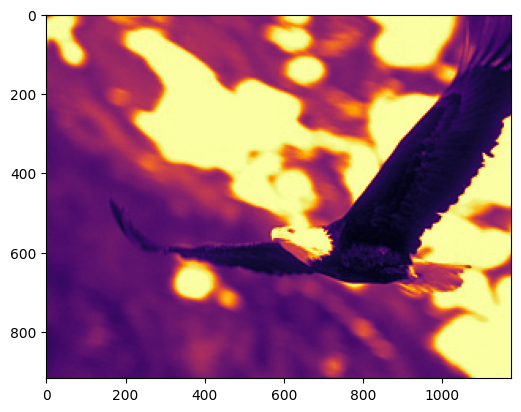

In [34]:
fig = plt.figure(figsize=(6,6))

# Use imshow to visualize any image in the list
plt.imshow(ns_img_list[100], cmap='inferno')

**GET DFF TRACES FOR EACH FRAME**

In [114]:
# remember ts = list of each frame, dff = ∆F/F at each frame

dff_stim_all=[] # dff_stim_all is a list of MAX dff over the interval of ONE natural scene presentation

def get_stim(start, end):
    i=start
    while i < end:
        j=experiment_data.get_stimulus(i)[0][2]['end']
        max_dff_stim=max(cell_dff[i:j])
        dff_stim_cell.append(max_dff_stim)
        i=experiment_data.get_stimulus(i)[0][2]['end']+1

for k in range(len(dff)):
    
    cell_dff=dff[k]
    dff_stim_cell=[]

    get_stim(ns_start1, ns_end1)
    get_stim(ns_start2, ns_end2)
    get_stim(ns_start3, ns_end3)

    dff_stim_all.append(dff_stim_cell)

In [118]:
# same idea, but doing mean dff over an interval

dff_stim_avg=[]

def get_stim_avg(start, end):
    i=start
    while i < end:
        j=experiment_data.get_stimulus(i)[0][2]['end']
        avg_dff_stim=sum(cell_dff[i:j])/len(cell_dff[i:j])
        dff_stim_cell.append(avg_dff_stim)
        i=experiment_data.get_stimulus(i)[0][2]['end']+1

for k in range(len(dff)):
    
    cell_dff=dff[k]
    dff_stim_cell=[]

    get_stim_avg(ns_start1, ns_end1)
    get_stim_avg(ns_start2, ns_end2)
    get_stim_avg(ns_start3, ns_end3)

    dff_stim_avg.append(dff_stim_cell)

In [42]:
# Get the cell specimens information for this experiment
cell_specimens = boc.get_cell_specimens(experiment_container_ids=[exp_container_id])
cell_specimens_df = pd.DataFrame(cell_specimens)
cell_specimens_df.head()

,all_stim,area,cell_specimen_id,donor_full_genotype,dsi_dg,experiment_container_id,failed_experiment_container,g_dsi_dg,g_osi_dg,g_osi_sg,...,specimen_id,tfdi_dg,time_to_peak_ns,time_to_peak_sg,tld1_id,tld1_name,tld2_id,tld2_name,tlr1_id,tlr1_name
0,False,VISp,662199586,Tlx3-Cre_PL56/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,NaN,627823571,False,NaN,NaN,NaN,...,603751387,NaN,NaN,NaN,265180449,Tlx3-Cre_PL56,None,None,528393470,Ai148(TIT2L-GC6f-ICL-tTA2)
1,False,VISp,662199605,Tlx3-Cre_PL56/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,0.793449,627823571,False,0.452460,0.360264,0.640623,...,603751387,0.265616,0.29916,0.29916,265180449,Tlx3-Cre_PL56,None,None,528393470,Ai148(TIT2L-GC6f-ICL-tTA2)
2,True,VISp,662199626,Tlx3-Cre_PL56/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,0.346550,627823571,False,0.346134,0.107403,0.943987,...,603751387,0.393678,0.29916,0.33240,265180449,Tlx3-Cre_PL56,None,None,528393470,Ai148(TIT2L-GC6f-ICL-tTA2)
3,False,VISp,662199645,Tlx3-Cre_PL56/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,0.636332,627823571,False,0.629502,0.971795,NaN,...,603751387,0.357068,NaN,NaN,265180449,Tlx3-Cre_PL56,None,None,528393470,Ai148(TIT2L-GC6f-ICL-tTA2)
4,False,VISp,662199683,Tlx3-Cre_PL56/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,NaN,627823571,False,NaN,NaN,0.524082,...,603751387,NaN,0.29916,0.33240,265180449,Tlx3-Cre_PL56,None,None,528393470,Ai148(TIT2L-GC6f-ICL-tTA2)


**ORIENTATION PREFERENCE BASED ON STATIC GRATING DATA**

In [45]:
# Get experiment for our container id and stimuli of interest
stim_2 = ['static_gratings']
sg_experiment = boc.get_ophys_experiments(
                        experiment_container_ids = [exp_container_id],
                        stimuli = stim_2)

# Download the experiment data using the experiment id
experiment_id_2 = sg_experiment[0]['id']
data_sg = boc.get_ophys_experiment_data(experiment_id_2)

print('Data acquired.')

Data acquired.


In [46]:
from allensdk.brain_observatory.static_gratings import StaticGratings

# Create my StaticGratings Object 
sg = StaticGratings(data_sg)

# Return dataframe of peak conditions
sg_df = sg.peak
sg_df.head()

,ori_sg,sf_sg,phase_sg,reliability_sg,osi_sg,peak_dff_sg,ptest_sg,time_to_peak_sg,cell_specimen_id,p_run_sg,cv_os_sg,run_modulation_sg,sf_index_sg
0,4,1,2,0.066467,1.004359,2.199624,0.0,0.3324,662200445,0.726179,0.534249,-0.325726,0.278232
1,2,3,0,0.062661,1.170665,10.776895,0.0,0.3324,662201985,0.462238,0.938336,0.546501,0.199625
2,4,2,1,0.082387,0.832164,8.087618,0.0,0.3324,662202542,0.179185,0.817209,-0.735372,0.274259
3,4,1,2,0.032702,1.312254,1.510278,0.076922,0.3324,662202121,0.585182,0.87537,-0.399784,0.231274
4,5,1,1,0.064972,0.97351,5.191792,0.0,0.29916,662202774,NaN,0.80322,NaN,0.275077


In [62]:
cell_specimen_id=sg_df['cell_specimen_id']
num_cells=len(cell_specimen_id)

In [63]:
sg_df['ori_sg']
# values range from 0 to 5, I believe it is as follows:
# 0 = 0°, 1 = 30°, 2 = 60°, 3 = 90°, 4 = 120°, 5 = 150°

0      4
1      2
2      4
3      4
4      5
      ..
117    3
118    5
119    5
120    5
121    4
Name: ori_sg, Length: 122, dtype: object

In [68]:
# multiplying by 30 and adding to list of preferred orientations
pref_ori = []
for i in range(num_cells):
    pref_ori.append(sg_df['ori_sg'][i]*30)

In [73]:
pref_ori_dict={
    'cell_specimen_id': cell_specimen_id,
    'pref_ori': pref_ori
}
pref_ori_df=pd.DataFrame(pref_ori_dict)
pref_ori_df

,cell_specimen_id,pref_ori
0,662200445,120
1,662201985,60
2,662202542,120
3,662202121,120
4,662202774,150
...,...,...
117,662200146,90
118,662202758,150
119,662202289,150
120,662200547,150


make sure cells with preferred orientations also in natural scenes experiment and vice versa

In [75]:
cell_ids=experiment_data.get_cell_specimen_ids()

In [77]:
cell_spec_id_ori=[]
pref_ori_cell=[]

for i in range(len(pref_ori_df['cell_specimen_id'])):
    if pref_ori_df['cell_specimen_id'][i] in cell_ids:
        cell_spec_id_ori.append(pref_ori_df['cell_specimen_id'][i])
        pref_ori_cell.append(pref_ori_df['pref_ori'][i])

In [78]:
subset_pref_ori_dict={
    'cell_specimen_id': cell_spec_id_ori,
    'pref_ori': pref_ori_cell
}
subset_pref_ori_df=pd.DataFrame(subset_pref_ori_dict)
subset_pref_ori_df

,cell_specimen_id,pref_ori
0,662200445,120
1,662201985,60
2,662202542,120
3,662202121,120
4,662202774,150
...,...,...
117,662200146,90
118,662202758,150
119,662202289,150
120,662200547,150


**SUBSET CELLS IN CALCIUM DATA FOR NS TO COVER CELLS SHOWN SG**

In [79]:
cell_id_subset=[]
dff_subset=[]

for i in range(len(cell_ids)): #122
    if cell_ids[i] in cell_spec_id_ori:
        cell_id_subset.append(cell_ids[i])
        dff_subset.append(dff_stim_all[i])

In [80]:
# making a data frame
dff_subset_tuple=list(zip(cell_id_subset, dff_subset))
dff_subset_dict=dict(dff_subset_tuple)
dff_subset_df=pd.DataFrame(dff_subset_dict)

In [81]:
dff_subset_df_tp=dff_subset_df.transpose()
dff_subset_df_index=dff_subset_df_tp.reset_index()
dff_final_subset_df=dff_subset_df_index.rename(columns={'index':'cell_specimen_id'})

In [82]:
dff_final_subset_df.sort_values(by='cell_specimen_id')

,cell_specimen_id,0,1,2,3,4,5,6,7,8,...,5940,5941,5942,5943,5944,5945,5946,5947,5948,5949
43,662199605,0.167642,0.064861,0.135688,0.070612,0.129162,0.046529,0.054602,0.081853,0.056152,...,0.020494,0.285016,0.186937,0.060037,0.073814,0.143216,0.070059,0.049977,0.069757,0.045263
56,662199626,0.054596,0.136722,0.032870,0.088378,0.073530,0.059529,0.115762,0.033307,-0.001438,...,0.058054,0.041255,0.018690,0.024749,0.043418,0.054393,0.099315,0.087189,0.089015,0.052602
18,662199683,0.033928,0.049662,0.089745,0.155822,0.068207,0.068313,0.045535,0.072766,0.100166,...,0.063175,0.067535,0.052037,0.097598,0.095612,0.044214,0.115603,0.072654,0.124300,0.036887
78,662199697,0.053499,0.110522,0.162646,0.096441,0.105932,0.094222,0.133430,0.019282,-0.009062,...,0.045748,0.151239,0.071879,0.124032,0.023992,0.040589,0.017555,0.016176,0.078045,0.043388
19,662199710,0.051823,0.034701,0.048006,0.139578,0.195919,0.077598,0.004267,0.043146,0.177640,...,0.052554,0.045330,0.124245,0.079501,0.081947,0.034650,0.081816,0.008232,0.043555,0.018292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,662203014,0.074786,0.016795,0.016794,0.078444,0.520596,0.081140,0.089170,0.045292,0.000000,...,0.063768,0.078038,0.099819,0.121784,0.063143,0.082356,0.044250,0.105411,0.030961,-0.013864
54,662203030,0.050910,0.020203,0.061460,0.071205,0.060717,0.063990,0.045410,0.038661,0.065864,...,0.041000,0.037607,0.051175,0.036997,0.044040,0.079430,-0.002537,-0.010046,0.056887,0.053288
80,662203048,0.009169,0.054028,0.084428,0.068259,0.115144,0.082728,0.125631,0.022886,0.013751,...,0.711828,0.182636,0.058724,0.106688,0.022741,0.003404,0.079508,0.018166,0.034682,0.158754
58,662203077,0.058942,0.077024,0.107479,0.053825,0.158810,0.087968,0.096658,0.215565,0.040005,...,0.062722,0.032794,0.070099,0.060250,0.097267,0.034927,0.050329,0.070232,0.063585,0.071734


SAME PROCESS, WITH MEAN DFF (i forgot about functions again dowwy)

In [87]:
cell_id_subset=[]
dff_mean_subset=[]

for i in range(len(cell_ids)): #122
    if cell_ids[i] in cell_spec_id_ori:
        cell_id_subset.append(cell_ids[i])
        dff_mean_subset.append(dff_stim_avg[i])

In [88]:
# making a data frame
mean_dff_subset_tuple=list(zip(cell_id_subset, dff_mean_subset))
mean_dff_subset_dict=dict(mean_dff_subset_tuple)
mean_dff_subset_df=pd.DataFrame(mean_dff_subset_dict)

In [89]:
mean_dff_final_subset_df=mean_dff_subset_df.transpose().reset_index().rename(columns={'index':'cell_specimen_id'})

In [90]:
mean_dff_final_subset_df

,cell_specimen_id,0,1,2,3,4,5,6,7,8,...,5940,5941,5942,5943,5944,5945,5946,5947,5948,5949
0,662200445,0.021476,-0.003370,-0.009565,-0.008111,0.020757,0.054042,0.084787,-0.032699,0.035164,...,-0.034707,0.034466,0.000414,0.009048,-0.014833,-0.017874,0.024688,0.004495,-0.006924,-0.004321
1,662201985,-0.012444,-0.014951,-0.006248,0.187440,0.107079,0.009243,-0.014802,-0.016251,-0.033454,...,-0.015752,-0.031811,-0.024269,0.009688,-0.029785,0.008217,0.017852,0.031506,0.010043,0.017322
2,662202542,0.016286,0.014050,0.026020,0.053816,0.041117,0.041079,0.029623,-0.041956,-0.022385,...,0.000662,-0.020766,-0.047090,-0.022997,-0.034997,-0.028587,0.003554,0.255408,0.034516,0.002603
3,662202121,-0.048793,0.050011,0.005676,0.042849,0.016447,0.002471,-0.049800,-0.026648,-0.003217,...,-0.070351,-0.045999,-0.045223,0.477831,0.270067,0.072950,0.071888,-0.011339,0.026066,-0.019680
4,662202774,-0.043869,-0.026313,-0.010424,0.017978,0.156792,0.001732,0.016314,0.024755,0.029325,...,0.044284,0.682296,0.263202,0.051300,0.046990,0.014324,-0.037585,0.032261,-0.021229,0.027097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,662200146,-0.029546,0.000624,-0.015099,-0.025938,-0.004463,0.019296,-0.016460,-0.074111,0.070279,...,0.002089,0.006564,-0.018260,0.015964,0.008850,-0.030506,-0.005345,0.040487,0.007995,-0.011428
118,662202758,-0.048390,-0.142544,0.113178,0.061462,0.157563,0.024535,0.027699,0.048158,0.031018,...,-0.095571,-0.107747,-0.029140,1.043000,0.449240,0.166941,0.229350,-0.010182,0.097616,0.006397
119,662202289,-0.027202,-0.001210,0.002870,0.001151,0.026727,0.030531,0.013038,-0.006586,-0.004861,...,0.001295,0.017183,-0.007861,-0.011172,-0.015872,0.006841,0.017495,-0.001890,-0.002560,0.006831
120,662200547,-0.009497,-0.061957,0.306376,0.024395,-0.038560,0.091301,1.051805,0.803371,0.311124,...,0.007704,0.018900,0.016967,0.052058,-0.017160,0.015935,-0.038743,-0.021810,0.039549,0.041992


**List of frame numbers for each natural scene presentation (better than a list of actual images themselves)**

In [119]:
ns_frame_list=[]

def get_frames(start,end):
    i=start
    while i < end:
        ns_frame_list.append(experiment_data.get_stimulus(i)[0][2]['frame'])
        i=experiment_data.get_stimulus(i)[0][2]['end']+1

get_frames(ns_start1, ns_end1)
get_frames(ns_start2, ns_end2)
get_frames(ns_start3, ns_end3)

In [108]:
ns_frame_dict={
    'frame': ns_frame_list
}
ns_frame_df=pd.DataFrame(ns_frame_dict)

In [105]:
## NO LONGER NEEDED - making an ordered list of images based on frame list to have a key of some sort

# frame_count=[]
# nonrepeat_ns_img_list=[]

# for i in range(len(ns_img_list)):
#     if ns_frame_list[i] not in frame_count:
#         frame_count.append(ns_frame_list[i])
#         nonrepeat_ns_img_list.append(ns_img_list[i])

# frame_img=list(zip(frame_count, nonrepeat_ns_img_list))

# frame_img_ordered=['None']*len(frame_img)

# for i in range(len(frame_img)):
#     frame_img_ordered[int(frame_img[i][0])+1]=frame_img[i]

# count, ordered_ns_img=list(zip(*frame_img_ordered))

In [106]:
# for i in range(len(ordered_ns_img)):
#     img=ordered_ns_img[i]
#     img_df=pd.DataFrame(img)
#     img_df.to_csv(f'./ordered_ns_img_csv/ns{i}.csv', sep=',', index=False)

**EXPORT DATAFRAMES AS CSVs**

In [112]:
# # preferred orientation for each cell (in order by cell specimen id)
# ordered_pref_ori_subset=subset_pref_ori_df.sort_values(by='cell_specimen_id').reset_index().drop(['index'], axis=1)
# ordered_pref_ori_subset.to_csv('pref_ori_ordered_subset.csv', sep=',', index=False)

In [110]:
## max dff for each NS presentation (in order by cell specimen id)
# ordered_dff_final_subset=dff_final_subset_df.sort_values(by='cell_specimen_id').reset_index().drop(['index'], axis=1)
# ordered_dff_final_subset.to_csv('max_dff_subset_ordered.csv', sep=',', index=False)

In [101]:
## mean dff for each NS presentation (in order by cell specimen id)
# ordered_mean_dff_subset=mean_dff_final_subset_df.sort_values(by='cell_specimen_id').reset_index().drop(['index'], axis=1)
# ordered_mean_dff_subset.to_csv('mean_dff_subset_ordered.csv', sep=',', index=False)

In [109]:
## frame of each natural scene presented throughout the experiment
# ns_stimulus_frame_presentation=ns_frame_df.to_csv('ns_stim_frame_presentation.csv', sep=',', index=False)

**SOME NICE VISUALS FOR EXAMPLES / ILLUSTRATING IDEAS**

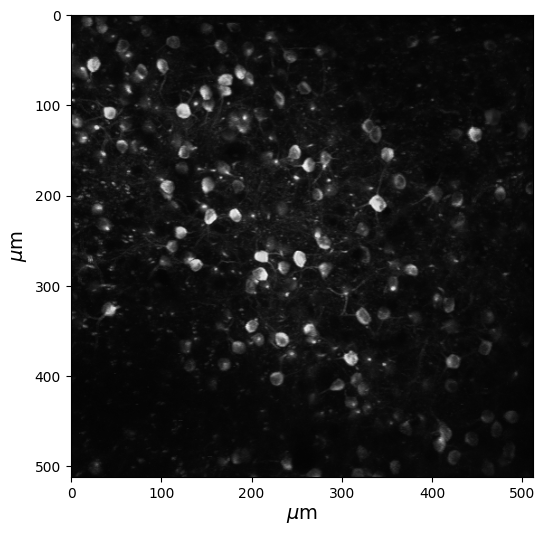

In [40]:
# Get the maximum projection (a numpy array) of our data
max_projection = experiment_data.get_max_projection()

# Create a new figure
fig = plt.figure(figsize=(6,6))

# Use imshow to visualize our numpy array
plt.imshow(max_projection, cmap='gray')

# Add labels for microns; weird syntax below is to get the micro sign
plt.ylabel(r'$\mu$m',fontsize=14)
plt.xlabel(r'$\mu$m',fontsize=14)
plt.show()

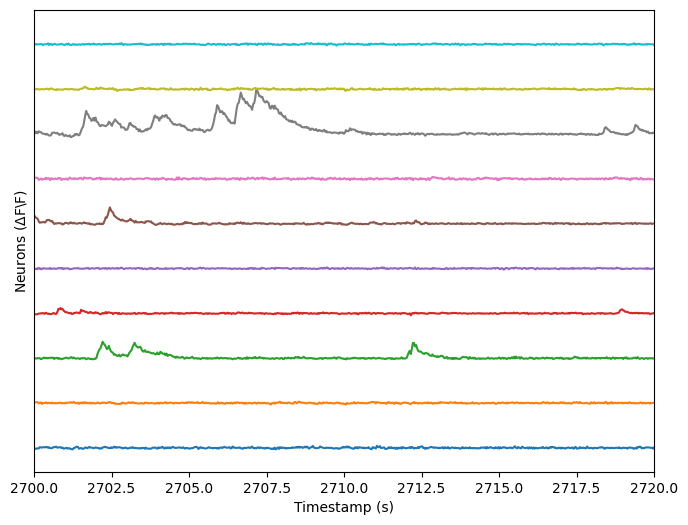

In [41]:
# Set up a figure
fig = plt.figure(figsize=(8,6))

# Loop through to add an offset on the y-axis
offset = 0
for cell in range(2,12):
    plt.plot(ts, dff[cell]+offset)
    offset+=5
    
plt.xlabel('Timestamp (s)')
plt.ylabel('Neurons ($\Delta$F\F)')
plt.yticks([])
plt.xlim([2700,2720])
plt.show()